# Import necassary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import wandb
import ast
import re
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import OneClassSVM
from simpletransformers.classification import ClassificationModel
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
torch.cuda.is_available()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Retrieve dataset and prepare it for the model

Index(['Unnamed: 0', 'names', 'contents', 'classIndex'], dtype='object')
Index(['contents', 'classIndex'], dtype='object')
[0 1]
[0 1]


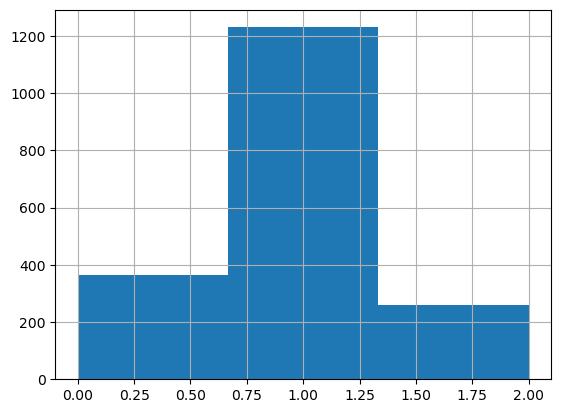

In [2]:
classesList = ['andere','factuur','aanmaning']

Dataset = pd.read_csv(os.getcwd() + "\\test_extraction_emails.csv")
Dataset['classIndex'].hist(bins=3)
print(Dataset.columns)
Dataset = Dataset.drop(['Unnamed: 0','names'],axis=1)
print(Dataset.columns)

def binaryDataset(dataset):
    dataset.loc[dataset['classIndex'] == 2, 'classIndex'] = 1
    return dataset

def reducedDataset(dataset):
    dataset = dataset.drop(dataset[dataset['classIndex'] == 0].index,axis=0)
    dataset.loc[dataset['classIndex'] == 1, 'classIndex'] = 0
    dataset.loc[dataset['classIndex'] == 2, 'classIndex'] = 1
    return dataset

primaryDataset = binaryDataset(Dataset.copy())
secondaryDataset = reducedDataset(Dataset.copy())

print(primaryDataset['classIndex'].unique())
print(secondaryDataset['classIndex'].unique())

### Split dataset into train/test set

In [3]:
primaryTrainSet, primaryTestSet = train_test_split(primaryDataset, test_size=0.1, stratify=primaryDataset['classIndex'], random_state=42)
secondaryTrainSet, secondaryTestSet = train_test_split(secondaryDataset, test_size=0.1, stratify=secondaryDataset['classIndex'], random_state=42)

### Define helper functions and variables

In [4]:
#check if CUDA capable gpu is available
cudaAvailable = torch.cuda.is_available()

def calculate_class_weights(trainingDataset):
    weightList = []
    numberOfLabels = len(trainingDataset['classIndex'].unique())
    for i in range(0,numberOfLabels):
        weight = len(trainingDataset.index) / (numberOfLabels * len(trainingDataset[trainingDataset['classIndex'] == i].index))
        weightList.append(weight)
    print(weightList)
    return weightList

# Define model/sweep and start training (pre-classifier)

In [5]:
sweepConfig = {'method' : 'grid', 'parameters' : {'num_train_epochs' : {'min' : 3, 'max' : 5}, 'learning_rate' : {'values' : [4e-5,5e-5,6e-5]}, 'train_batch_size' : {'values' : [16,32]}}}
sweepID = wandb.sweep(sweepConfig, project='Test sweep')

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

def train():
    wandb.init()
    trainArgumentsSweep = {'reprocess_input_data' : True, 'use_multiprocessing' : True, 'overwrite_output_dir' : True, 'use_early_stopping' : True, 'early_stopping_consider_epochs' : True, 'optimizer' : 'AdamW', 'save_model_every_epoch' : False, 'wandb_project' : 'Test sweep pre classifier'}
    classifierSweep = ClassificationModel("bert","GroNLP/bert-base-dutch-cased", num_labels=len(primaryTrainSet['classIndex'].unique()),args=trainArgumentsSweep, use_cuda=True, weight=calculate_class_weights(primaryTrainSet), sweep_config=wandb.config)
    classifierSweep.train_model(primaryTrainSet)
    result, model_outputs, wrong_predictions = classifierSweep.eval_model(primaryTestSet, f1=f1_multiclass, confusionMatrix=confusion_matrix)
    wandb.log({'mcc' : result['mcc'], 'f1' : result['f1'], 'confusion_matrix' : result['confusionMatrix']})
    wandb.join()
    
wandb.agent(sweepID, train)

Create sweep with ID: mcxfu8so
Sweep URL: https://wandb.ai/spacehack100/Test%20sweep/sweeps/mcxfu8so


wandb: Agent Starting Run: 1dr4pzwq with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 16
wandb: Currently logged in as: spacehack100. Use `wandb login --relogin` to force relogin


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.


Training loss,▅▃▃█▁▁
f1,▁
global_step,▁▂▄▅▇█
lr,█▇▅▄▂▁
mcc,▁
Training loss,0.01439
f1,0.95699
global_step,300
lr,0.0
mcc,0.86505


wandb: Agent Starting Run: 3whlraic with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,█▂▁
f1,▁
global_step,▁▅█
lr,█▅▁
mcc,▁
Training loss,0.12886
f1,0.91935
global_step,150
lr,0.0
mcc,0.74447


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: skyzejmo with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 16


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,█▃▄▃▄▃▁▁
f1,▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▆▅▄▃▂▁
mcc,▁
Training loss,0.00057
f1,0.94086
global_step,400
lr,0.0
mcc,0.80971


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4eylz36o with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,█▄▁▁
f1,▁
global_step,▁▃▆█
lr,█▆▃▁
mcc,▁
Training loss,0.06726
f1,0.94086
global_step,200
lr,0.0
mcc,0.80678


wandb: Agent Starting Run: hh2ad9vt with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 16


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▃▂▂▇█▁▁▁▁▁
f1,▁
global_step,▁▂▃▃▄▅▆▆▇█
lr,█▇▆▆▅▄▃▃▂▁
mcc,▁
Training loss,0.00149
f1,0.94086
global_step,500
lr,0.0
mcc,0.81265


wandb: Agent Starting Run: n4h8f2pn with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▅▄█▁▁
f1,▁
global_step,▁▃▅▆█
lr,█▆▅▃▁
mcc,▁
Training loss,0.00214
f1,0.95161
global_step,250
lr,0.0
mcc,0.84456


wandb: Agent Starting Run: 3pd4i4vo with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 16


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,█▃▄▁▃▁
f1,▁
global_step,▁▂▄▅▇█
lr,█▇▅▄▂▁
mcc,▁
Training loss,0.0744
f1,0.94086
global_step,300
lr,0.0
mcc,0.81265


wandb: Agent Starting Run: pedyx5n8 with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▂█▁
f1,▁
global_step,▁▅█
lr,█▄▁
mcc,▁
Training loss,0.0691
f1,0.93011
global_step,150
lr,0.0
mcc,0.77856


wandb: Agent Starting Run: 6elpqxiq with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 16


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▂█▁▂▁▁▁▁
f1,▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▆▅▄▃▂▁
mcc,▁
Training loss,0.00046
f1,0.91935
global_step,400
lr,0.0
mcc,0.73354


wandb: Agent Starting Run: nsyfh4lr with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,█▄▇▁
f1,▁
global_step,▁▃▆█
lr,█▆▃▁
mcc,▁
Training loss,0.00887
f1,0.94086
global_step,200
lr,0.0
mcc,0.80971


wandb: Agent Starting Run: t17l4g8h with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 16


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▄▃▃▁█▁▁▁▁▁
f1,▁
global_step,▁▂▃▃▄▅▆▆▇█
lr,█▇▆▆▅▄▃▃▂▁
mcc,▁
Training loss,0.00039
f1,0.96237
global_step,500
lr,0.0
mcc,0.8794


wandb: Agent Starting Run: iwkbw2ha with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▇▃█▁▁
f1,▁
global_step,▁▃▅▆█
lr,█▆▄▃▁
mcc,▁
Training loss,0.00115
f1,0.93548
global_step,250
lr,0.0
mcc,0.79095


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6opm9i3t with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 16


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▄▅▃██▁
f1,▁
global_step,▁▂▄▅▇█
lr,█▇▅▄▂▁
mcc,▁
Training loss,0.0034
f1,0.93011
global_step,300
lr,0.0
mcc,0.77486


wandb: Agent Starting Run: 8boms3dc with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,█▂▁
f1,▁
global_step,▁▅█
lr,█▅▁
mcc,▁
Training loss,0.01151
f1,0.93548
global_step,150
lr,0.0
mcc,0.79095


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 90a47kzc with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 16


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▇█▄▆▁▁▁▁
f1,▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▆▅▄▃▂▁
mcc,▁
Training loss,0.00069
f1,0.94624
global_step,400
lr,0.0
mcc,0.82621


wandb: Agent Starting Run: kweysoqt with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▇█▁▂
f1,▁
global_step,▁▃▆█
lr,█▆▃▁
mcc,▁
Training loss,0.11668
f1,0.93548
global_step,200
lr,0.0
mcc,0.79095


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yovuayrt with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 16


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▂█▂▁▁▁▁▁▁▁
f1,▁
global_step,▁▂▃▃▄▅▆▆▇█
lr,█▇▆▆▅▄▃▃▂▁
mcc,▁
Training loss,0.00027
f1,0.95699
global_step,500
lr,0.0
mcc,0.86276


wandb: Agent Starting Run: 4f5gj29e with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▅▄█▁▆
f1,▁
global_step,▁▃▅▆█
lr,█▆▄▃▁
mcc,▁
Training loss,0.28205
f1,0.95699
global_step,250
lr,0.0
mcc,0.86146


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### Move best result into sepperate model (pre-classifier)

In [14]:
wandb.init()
trainArguments = {'output_dir' : "outputs_pre_classifier/", 'reprocess_input_data' : True, 'use_multiprocessing' : True, 'num_train_epochs' : 5, 'overwrite_output_dir' : True, 'use_early_stopping' : True, 'early_stopping_consider_epochs' : True, 'train_batch_size' : 16, 'optimizer' : 'AdamW', 'save_model_every_epoch' : False, 'logging_steps' : 25, 'learning_rate' : 5e-5, 'wandb_project' : 'Test binary pre-classifier', 'wandb_kwargs' : {'magic' : True}}
preClassifier = ClassificationModel("bert","GroNLP/bert-base-dutch-cased", num_labels=len(primaryTrainSet['classIndex'].unique()),args=trainArguments, use_cuda=True, weight=calculate_class_weights(primaryTrainSet))
preClassifier.train_model(primaryTrainSet)

[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/105 [00:00<?, ?it/s]

(525, 0.17773370795218008)

### Evaluate the resulting model against test set

In [15]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

result, model_outputs, wrong_predictions = preClassifier.eval_model(primaryTestSet, f1=f1_multiclass, confusionMatrix=confusion_matrix)
print(result)

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▃█▆▃▇▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁
global_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
lr,▇██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
Training loss,0.00017
global_step,525
lr,0.0


{'mcc': 0.797569381461999, 'tp': 143, 'tn': 31, 'fp': 6, 'fn': 6, 'auroc': 0.9505713767458733, 'auprc': 0.9831610567873725, 'f1': 0.9354838709677419, 'confusionMatrix': array([[ 31,   6],
       [  6, 143]], dtype=int64), 'eval_loss': 0.6692023249097474}


In [16]:
print(type(wrong_predictions[0]))
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = str(wrong_predictions[i])
    #wrong_predictions[i] = re.sub("'","\"",wrong_predictions[i])
print(type(wrong_predictions[0]))
print(wrong_predictions[0])
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = ast.literal_eval(wrong_predictions[i])
print(type(wrong_predictions[0]))
wrong_predictions_df = pd.DataFrame(wrong_predictions)
wrong_predictions_df = wrong_predictions_df.rename(columns={'guid' : 'testSet_id', 'text_a' : 'text', 'text_b' : 'pred_label', 'label' : 'true_label'})
for i, row in wrong_predictions_df.iterrows():   
    wrong_predictions_df.iloc[i,2] = np.argmax(model_outputs[int(row['testSet_id'])])
wrong_predictions_df

<class 'simpletransformers.classification.classification_utils.InputExample'>
<class 'str'>
{'guid': 7, 'text_a': 'Hey Deze factuur staat op DPG media services dus voor suppliers Gelieve te boeken op door te boeken naar DPG Media NV op HR BE Ik vermoed door te boeken op DPG Media BV op HR NL Alvast bedankt Met vriendelijk groeten Isabelle De Lentdecker Management assistant ICT image DPG Media Mediaplein Antwerpen T isabelledelentdeckerdpgmediabe dpgmediabe image DPG Media dots Op ma sep om schreef Sara Tonino DPG Media saratoninodpgmedianl Hi Collegas Bij deze mijn akkoord om deze factuur te betalen vanuit IT Kleine notitie van deze factuur zal Jacomine de Visser en Sarah Coolkens ieder euro betalen De rest dus euro is voor IT Lukt het zo om dit in jullie administratie te verwerken Hoor graag let me know thanks Mvg Sara Tonino Forwarded message Van Egotribe BV Subject Factuur To Sara Tonino Cc Geachte heermevrouw Bijgaand de factuur met nummer voor de diensten zoals beschreven als besp

testSet_id  \
0            7   
1           24   
2           31   
3           41   
4           76   
5           80   
6           93   
7          100   
8          103   
9          121   
10         138   
11         160   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

### Save model localy

# Pre-classifier with one-class SVM

In [8]:
print(primaryTrainSet.isna().sum().sum())
print(primaryTestSet.isna().sum().sum())
primaryTrainSet = primaryTrainSet.dropna()
primaryTestSet = primaryTestSet.dropna()

primaryTrainSet.loc[primaryTrainSet['classIndex'] == 0, 'classIndex'] = -1
primaryTestSet.loc[primaryTestSet['classIndex'] == 0, 'classIndex'] = -1
primaryTrainText = primaryTrainSet['contents'].tolist()
primaryTrainLabel = primaryTrainSet['classIndex'].tolist()
primaryTestText = primaryTestSet['contents'].tolist()
primaryTestLabel = primaryTestSet['classIndex'].tolist()

vectorizer = TfidfVectorizer()
trainVectors = vectorizer.fit_transform(primaryTrainText)
testVectors = vectorizer.transform(primaryTestText)

GarbageSeperator = OneClassSVM(gamma='auto')
GarbageSeperator.fit(trainVectors)

testPredictions = GarbageSeperator.predict(testVectors)
print('f1 score: ', f1_score(primaryTestLabel,testPredictions, average='micro'))
print('mcc score: ', matthews_corrcoef(primaryTestLabel,testPredictions))
print(confusion_matrix(primaryTestLabel,testPredictions))

0
0
f1 score:  0.6864864864864865
mcc score:  0.11175167395948687
[[ 13  24]
 [ 34 114]]


Doesn't work well for this scenario (low f1 and extremely low mcc -> very random)

# Define model/sweep and start training (multiclass)

In [ ]:
sweepConfig = {'method' : 'grid', 'parameters' : {'num_train_epochs' : {'min' : 3, 'max' : 5}, 'learning_rate' : {'values' : [4e-5,5e-5,6e-5]}, 'train_batch_size' : {'values' : [16,32]}}}
sweepID = wandb.sweep(sweepConfig, project='Test sweep')

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

def train():
    wandb.init()
    trainArgumentsSweep = {'reprocess_input_data' : True, 'use_multiprocessing' : True, 'overwrite_output_dir' : True, 'use_early_stopping' : True, 'early_stopping_consider_epochs' : True, 'optimizer' : 'AdamW', 'save_model_every_epoch' : False, 'wandb_project' : 'Test sweep'}
    classifierSweep = ClassificationModel("bert","GroNLP/bert-base-dutch-cased", num_labels=len(secondaryTrainSet['classIndex'].unique()),args=trainArgumentsSweep, use_cuda=True, weight=calculate_class_weights(secondaryTrainSet), sweep_config=wandb.config)
    classifierSweep.train_model(secondaryTrainSet)
    result, model_outputs, wrong_predictions = classifierSweep.eval_model(secondaryTestSet, f1=f1_multiclass, confusionMatrix=confusion_matrix)
    wandb.log({'mcc' : result['mcc'], 'f1' : result['f1'], 'confusion_matrix' : result['confusionMatrix']})
    wandb.join()
    
wandb.agent(sweepID, train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: sw2jrb0y
Sweep URL: https://wandb.ai/spacehack100/Test%20sweep/sweeps/sw2jrb0y


wandb: Agent Starting Run: vwxedsqv with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 16
wandb: WARNING wandb.init() arguments ignored because wandb magic has already been initialized


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,█▇▁▅▂▁
f1,▁
global_step,▁▂▄▅▇█
lr,█▇▅▄▂▁
mcc,▁
Training loss,0.02284
f1,0.93548
global_step,300
lr,0.0
mcc,0.79095


wandb: Agent Starting Run: s749c59o with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 32


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/53 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,█▄▁
f1,▁
global_step,▁▅█
lr,█▅▁
mcc,▁
Training loss,0.01054
f1,0.94086
global_step,150
lr,0.0
mcc,0.81642


wandb: Agent Starting Run: h3m7onsf with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 16


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/105 [00:00<?, ?it/s]

### Move best result into sepperate model (multiclass)

In [13]:
wandb.init()
trainArguments = {'output_dir' : "outputs_pre_classifier/", 'reprocess_input_data' : True, 'use_multiprocessing' : True, 'num_train_epochs' : 3, 'overwrite_output_dir' : True, 'use_early_stopping' : True, 'early_stopping_consider_epochs' : True, 'train_batch_size' : 16, 'optimizer' : 'AdamW', 'save_model_every_epoch' : False, 'logging_steps' : 25, 'learning_rate' : 6e-5, 'wandb_project' : 'Test binary pre-classifier', 'wandb_kwargs' : {'magic' : True}}
multiClassifier = ClassificationModel("bert","GroNLP/bert-base-dutch-cased", num_labels=len(secondaryTrainSet['classIndex'].unique()),args=trainArguments, use_cuda=True, weight=calculate_class_weights(secondaryTrainSet))
multiClassifier.train_model(secondaryTrainSet)

wandb: Currently logged in as: spacehack100. Use `wandb login --relogin` to force relogin


[2.5364741641337387, 0.6227611940298508]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1669 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/105 [00:00<?, ?it/s]

(315, 0.2687401317109886)

### Evaluate the resulting model against test set

In [14]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

result, model_outputs, wrong_predictions = multiClassifier.eval_model(secondaryTestSet, f1=f1_multiclass, confusionMatrix=confusion_matrix)
print(result)

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

Training loss,▆▇▂▃▁▂█▃▁▁▁▁
global_step,▁▂▂▃▄▄▅▅▆▇▇█
lr,█▇▇▆▅▅▄▄▃▂▂▁
Training loss,0.00183
global_step,300
lr,0.0


wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.


{'mcc': 0.7748636381859083, 'tp': 144, 'tn': 29, 'fp': 8, 'fn': 5, 'auroc': 0.9617268274986396, 'auprc': 0.9880367246658823, 'f1': 0.9301075268817204, 'confusionMatrix': array([[ 29,   8],
       [  5, 144]], dtype=int64), 'eval_loss': 0.625563353287968}


In [15]:
print(type(wrong_predictions[0]))
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = str(wrong_predictions[i])
    #wrong_predictions[i] = re.sub("'","\"",wrong_predictions[i])
print(type(wrong_predictions[0]))
print(wrong_predictions[0])
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = ast.literal_eval(wrong_predictions[i])
print(type(wrong_predictions[0]))
wrong_predictions_df = pd.DataFrame(wrong_predictions)
wrong_predictions_df = wrong_predictions_df.rename(columns={'guid' : 'testSet_id', 'text_a' : 'text', 'text_b' : 'pred_label', 'label' : 'true_label'})
for i, row in wrong_predictions_df.iterrows():   
    wrong_predictions_df.iloc[i,2] = np.argmax(model_outputs[int(row['testSet_id'])])
wrong_predictions_df

<class 'simpletransformers.classification.classification_utils.InputExample'>
<class 'str'>
{'guid': 7, 'text_a': 'Hey Deze factuur staat op DPG media services dus voor suppliers Gelieve  te boeken op   door te boeken naar DPG Media NV op HR BE  Ik vermoed     door te boeken op DPG Media BV op HR NL Alvast bedankt Met vriendelijk groeten Isabelle De Lentdecker Management assistant ICT image DPG Media Mediaplein   Antwerpen T   isabelledelentdeckerdpgmediabe dpgmediabe image DPG Media dots Op ma  sep  om  schreef Sara Tonino  DPG Media  saratoninodpgmedianl  Hi Collegas   Bij deze mijn akkoord om deze factuur te betalen vanuit IT   Kleine notitie van deze factuur zal Jacomine de Visser  en Sarah Coolkens  ieder  euro betalen De rest dus   euro is voor IT   Lukt het zo om dit in jullie administratie te verwerken Hoor graag let  me know thanks    Mvg Sara Tonino    Forwarded message   Van Egotribe BV  Subject Factuur   To Sara Tonino  Cc       Geachte heermevrouw   Bijgaand de factuur met

testSet_id  \
0            7   
1            9   
2           24   
3           31   
4           38   
5           41   
6           76   
7           80   
8           88   
9           93   
10         100   
11         149   
12         160   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

# Do some predictions to see if results are worse on when seperated by binary classifier

# Conclusion:
BERTje is able to classify emails with high accuracy and percision, but is significantly slower to train or use inference on. However, this can be mitigated by using a more powerfull gpu (at least for training)
- Avg training time with Nvidia RTX 3070 mobile (at 100W tdp) = ~8 seconds per epoch (batch size of 64)
- Avg training time with Nvidia Quadro t1000 mobile (at 50W tdp) = ~7-8 minutes per epoch (batch size of 16)

Conclusion on data: accuracy is heavily influenced by the amount -> each category will need a lot off data

# Sources:
- https://www.philschmid.de/bert-text-classification-in-a-different-language
- https://huggingface.co/GroNLP/bert-base-dutch-cased
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html
- https://huggingface.co/docs/transformers/perf_train_gpu_one
- https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights
- https://stackoverflow.com/questions/60462444/one-class-svm-model-for-text-classification-scikit-learn